# **Titanic Kaggle Competition Predictions**

# Importing the libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import xgboost
import matplotlib.pyplot as plt
import warnings
import seaborn as sn
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Importing the data

In [2]:
training_set = pd.read_csv('/kaggle/input/titanic/train.csv')
test_set = pd.read_csv('/kaggle/input/titanic/test.csv')

# Data exploration

In [3]:
training_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Removing columns

In [5]:
training_set.drop(columns=['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_set.drop(columns=['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Unknown data

In [6]:
# filling unknown data with mean/median

print(training_set.isnull().sum())
print(test_set.isnull().sum())

training_set['Age'].fillna(training_set['Age'].median(), inplace=True)
training_set['Embarked'].fillna(training_set['Embarked'].mode(), inplace=True)
test_set['Age'].fillna(test_set['Age'].median(), inplace=True)
test_set['Fare'].fillna(test_set['Fare'].median(), inplace=True)

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64
PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64


# Removing outliers

In [7]:
def box_plot(column):
    training_set.boxplot(by = "Survived",column = [column],grid = True)
    
# Small circles or unfilled dots are drawn on the chart to indicate where suspected outliers lie.
# Filled circles are used for known outliers.

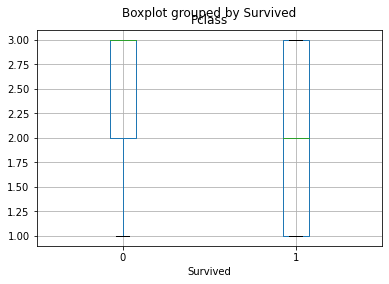

In [8]:
box_plot("Pclass")

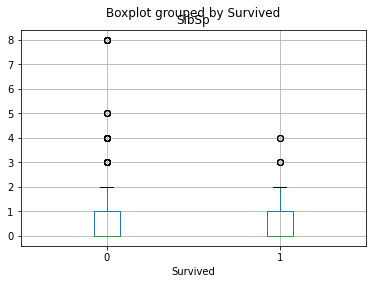

In [9]:
box_plot("SibSp")

In [10]:
training_set["SibSp"].value_counts()
indexes = training_set.index[training_set.SibSp == 8]
training_set.drop(indexes, inplace=True)

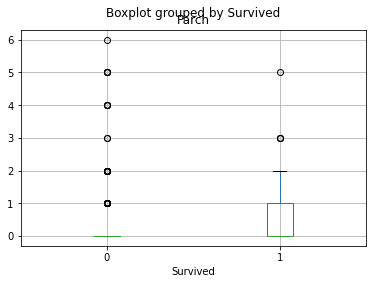

In [11]:
box_plot("Parch")

In [12]:
training_set["Parch"].value_counts()

0    678
1    118
2     73
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

In [13]:
indexes = training_set.index[training_set.Parch == 6]
training_set.loc[indexes]
training_set.drop(indexes, inplace=True)

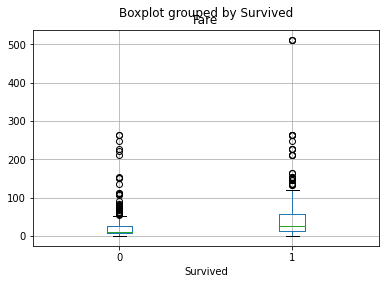

In [14]:
box_plot("Fare")

In [15]:
training_set["Fare"].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
50.4958     1
13.8583     1
8.4583      1
7.7250      1
7.5208      1
Name: Fare, Length: 247, dtype: int64

In [16]:
indexes = training_set.index[training_set.Fare > 100]
training_set.loc[indexes]
indexes
training_set.drop(indexes, inplace=True)

# Correlation matrix

<AxesSubplot:>

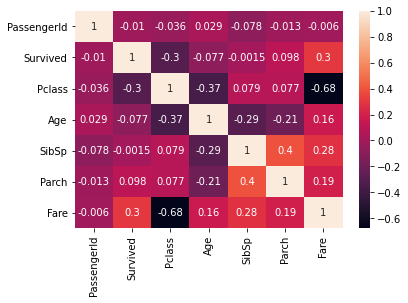

In [17]:
correlation_matrix = training_set.corr()
sn.heatmap(correlation_matrix, annot = True)

In [18]:
test_set.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


1. Survival rate PClass

In [19]:
training_set.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


[1 2 3]
Survival rate classes: 
[0.6, 0.47, 0.25]


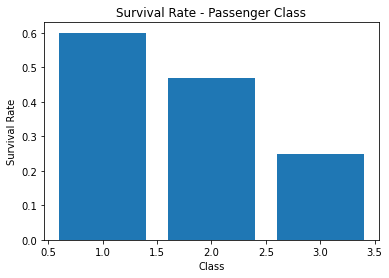

In [20]:
classes = training_set.Pclass.unique()
classes.sort()
survival_rate_classes = []
# .loc - get rows by the name of a column

for i in classes:
    class_i = training_set.loc[training_set.Pclass == i]["Survived"]
    survival_rate_classes.append(round(sum(class_i)/len(class_i),2))

print(classes)
print('Survival rate classes: ')
print(survival_rate_classes)


plt.bar(classes, survival_rate_classes)
plt.title("Survival Rate - Passenger Class")
plt.xlabel("Class")
plt.ylabel("Survival Rate")
plt.show()

2. Survival rate per Sex

Survival rates: 
[0.18, 0.73]


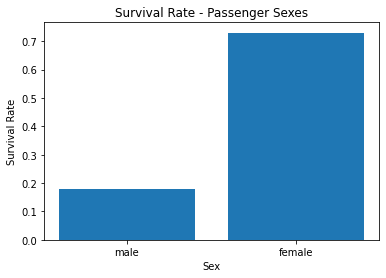

In [21]:
sex = training_set.Sex.unique()
survival_rate_sex = []

for i in sex:
    sex_i = training_set.loc[training_set.Sex == i]["Survived"]
    survival_rate_sex.append(round(sum(sex_i)/len(sex_i),2))
    
print('Survival rates: ')
print(survival_rate_sex)

plt.bar(sex, survival_rate_sex)
plt.title("Survival Rate - Passenger Sexes")
plt.xlabel("Sex")
plt.ylabel("Survival Rate")
plt.show()

3. Survival rate per Age bucket

In [22]:
max_age = max(training_set.Age)
AgeGroup = pd.cut(round(training_set.Age), bins = 5, labels=["1", "2", "3", "4", "5"], ordered = True)
print('Age categories: ')
age_categories = AgeGroup.unique()

survival_rate_age = []

for i in range(1,6):
    cat = training_set.loc[AgeGroup == str(i)]["Survived"]
    survival_rate_age.append(round(sum(cat)/len(cat),2))
    print(i)
    print(survival_rate_age)

Age categories: 
1
[0.54]
2
[0.54, 0.33]
3
[0.54, 0.33, 0.36]
4
[0.54, 0.33, 0.36, 0.43]
5
[0.54, 0.33, 0.36, 0.43, 0.09]


4. Survival rate by # of siblings / spouses aboard the Titanic

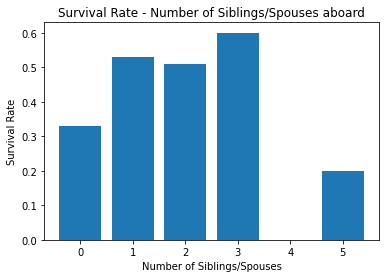

In [23]:
sibsp_categories = []
sibsp_categories = training_set.Parch.unique()
sibsp_categories.sort()

survival_rate_sibsp = []

for i in sibsp_categories:
    cat = training_set.loc[training_set.Parch == i]["Survived"]
    survival_rate_sibsp.append(round(sum(cat)/len(cat),2))

plt.bar(sibsp_categories, survival_rate_sibsp)
plt.title("Survival Rate - Number of Siblings/Spouses aboard")
plt.xlabel("Number of Siblings/Spouses")
plt.ylabel("Survival Rate")
plt.show()

5. Survival rate by # of parents / children aboard the Titanic

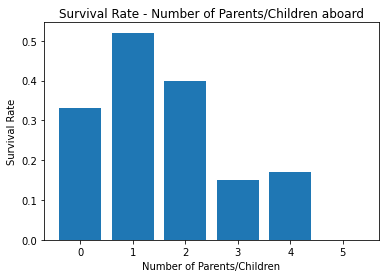

In [24]:
parch_categories = []
parch_categories = training_set.SibSp.unique()
parch_categories.sort()

survival_rate_parch = []

for i in parch_categories:
    cat = training_set.loc[training_set.SibSp == i]["Survived"]
    survival_rate_parch.append(round(sum(cat)/len(cat),2))

plt.bar(parch_categories, survival_rate_parch)
plt.title("Survival Rate - Number of Parents/Children aboard")
plt.xlabel("Number of Parents/Children")
plt.ylabel("Survival Rate")
plt.show()

6. Fare

In [25]:
# Fare - feature scaling

7. Port of Embarkation

# Categorical data

In [26]:
training_set = pd.get_dummies(training_set, columns=['Pclass', 'Sex', 'Embarked' ], drop_first= True)
test_set = pd.get_dummies(test_set, columns=['Pclass', 'Sex', 'Embarked' ], drop_first= True)

# Creating the matrix of features and dependent variable vector

In [27]:
x_train = training_set.iloc[:,training_set.columns != 'Survived']
y_train = training_set.iloc[:,training_set.columns == 'Survived'].values.reshape(-1,1)

x_test = test_set

# Standard scaling

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_to_scale = ['Age','SibSp','Parch','Fare']

x_train[features_to_scale] = scaler.fit_transform(x_train[features_to_scale])
x_test[features_to_scale] = scaler.fit_transform(x_test[features_to_scale])

****

# Fitting the model

# Support Vector Machine
Random Forest
Extreme Gradient Boosting

In [29]:
from sklearn.svm import SVC
classifier_svm = SVC(kernel = 'linear', random_state = 0)

print(x_train)
classifier_svm.fit(x_train, y_train)

     PassengerId       Age     SibSp     Parch      Fare  Pclass_2  Pclass_3  \
0              1 -0.554792  0.621076 -0.440288 -0.720891         0         1   
1              2  0.675557  0.621076 -0.440288  2.411879         0         0   
2              3 -0.247205 -0.509391 -0.440288 -0.687867         0         1   
3              4  0.444867  0.621076 -0.440288  1.522278         0         0   
4              5  0.444867 -0.509391 -0.440288 -0.681752         0         1   
..           ...       ...       ...       ...       ...       ...       ...   
886          887 -0.170308 -0.509391 -0.440288 -0.439577         1         0   
887          888 -0.785482 -0.509391 -0.440288  0.392132         0         0   
888          889 -0.093411  0.621076  2.236919  0.071679         0         1   
889          890 -0.247205 -0.509391 -0.440288  0.392132         0         0   
890          891  0.214176 -0.509391 -0.440288 -0.696429         0         1   

     Sex_male  Embarked_Q  Embarked_S  

SVC(kernel='linear', random_state=0)

In [30]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(random_state = 0)
classifier_rf.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In [31]:
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier()
classifier_xgb.fit(x_train, y_train)

[17:11:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
from sklearn.linear_model import LogisticRegression
classifier_lr = LogisticRegression()
classifier_lr.fit(x_train, y_train)

LogisticRegression()

# Predicting the test set results

In [33]:
y_pred_svm = classifier_svm.predict(x_test)
y_pred_rf = classifier_rf.predict(x_test)
y_pred_xgb = classifier_xgb.predict(x_test)
y_pred_lr = classifier_lr.predict(x_test)

# Confusion matrix and accuracy

In [34]:
#from sklearn.metrics import confusion_matrix, accuracy_score
#cm = confusion_matrix(y_test, y_pred)
#print(cm)
#accuracy = accuracy_score(y_test, y_pred)
#print(accuracy)

# Output

In [35]:
#output = pd.DataFrame({'PassengerId': test_set.PassengerId, 'Survived': y_pred_svm})

#output = pd.DataFrame({'PassengerId': test_set.PassengerId, 'Survived': y_pred_rf})

output = pd.DataFrame({'PassengerId': test_set.PassengerId, 'Survived': y_pred_xgb})

#output = pd.DataFrame({'PassengerId': test_set.PassengerId, 'Survived': y_pred_lr})
output.to_csv('my_submission_xgb.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
